In [1]:
from os import scandir
opus_name = next(file.name for file in scandir() if file.name.endswith('txt'))
opus_name

'pan-tadeusz.txt'

In [2]:
def auto_open (encoding='utf-8', **kwargs):
    def decorator (fn):
        def wrapper (filename, *args):
            with open(filename, encoding=encoding, **kwargs) as file:
                return fn(*args, file=file)
        return wrapper
    return decorator

In [3]:
@auto_open()
def read_lines (file):
    lines = (line.strip() for line in file.readlines())
    return filter(None, lines)

opus_lines = list(read_lines(opus_name))
opus_lines

['Adam Mickiewicz',
 'Pan Tadeusz czyli ostatni zajazd na Litwie',
 'ISBN 978-83-288-2495-9',
 'Księga pierwsza',
 'Gospodarstwo',
 'Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami — Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy',
 'Litwo! Ojczyzno moja! ty jesteś jak zdrowie:',
 'Ile cię trzeba cenić, ten tylko się dowie,',
 'Kto cię stracił. Dziś piękność twą w całej ozdobie',
 'Widzę i opisuję, bo tęsknię po tobie.',
 'Panno święta, co Jasnej bronisz Częstochowy',
 'I w Ostrej świecisz Bramie! Ty, co gród zamkowy',
 'Nowogródzki ochraniasz z jego wiernym ludem!',
 'Jak mnie dziecko do zdrowia powróciłaś cudem',
 '(Gdy od płaczącej matki, pod Twoją opiekę',
 'Ofiarowany, martwą podniosłem powiekę;',
 'I zaraz mogłem pieszo, do Twych świątyń progu',
 'Iść za wrócone życie podziękować Bogu),',
 'Tak nas pow

In [4]:
import re

In [5]:
def matching_lines (lines, pattern):
    return [(idx, line) for idx, line in enumerate(lines)
           if re.search(pattern, line)]

In [6]:
def extract_chapters (lines, origins, scope=(None, None)):
    
    def locate_chapters (*, pattern, headskip=0, titleskip=0):
        return ((index, index+headskip, lines[index+titleskip]) 
                for index, _ in matching_lines(lines, pattern))
    
    from itertools import chain
    locations = (locate_chapters(**rule) for rule in origins)
    begin = (0, 0, lines[0])
    end = (len(lines), len(lines), '')
    endpoints = sorted(chain([begin], *locations, [end]))
    pairs = zip(endpoints, endpoints[1:])
    
    def chapter (begin, end):
        _, first, first_line = begin
        last, _, _ = end
        return first_line, lines[first:last]

    return [chapter(begin, end) for begin, end in pairs][slice(*scope)]

In [7]:
def load_opus (filename, rules_filename=None):
    import re, json
    if not rules_filename:
        rules_filename = re.sub(r'\.\w*?$', '.chapter-rules.json', filename)
        print(rules_filename)
        
    @auto_open()
    def load_rules(file):
        return json.load(file)
    
    lines = list(read_lines(filename))
    rules = load_rules(rules_filename)
    return extract_chapters(lines, **rules)

In [8]:
def linearize (chapters):
    from itertools import accumulate, chain
    names, contents = zip(*chapters)
    
    lengths = [len(chapter) for chapter in contents]
    origins = accumulate([0] + lengths)
    table_of_contents = list(zip(origins, lengths, names))
    
    aggregated_contents = list(chain(*contents))
    return table_of_contents, aggregated_contents

In [12]:
toc, verses = linearize(load_opus('pan-tadeusz.txt'))

pan-tadeusz.chapter-rules.json


In [13]:
def pattern_counts(lines, pattern, flags=0):
    def count(line):
        return len(re.findall(pattern, line, flags))
    return [count(line) for line in lines]

In [15]:
counts = pattern_counts(verses, 'Litw|Litew', flags=re.IGNORECASE)

In [16]:
import matplotlib.pyplot as plt

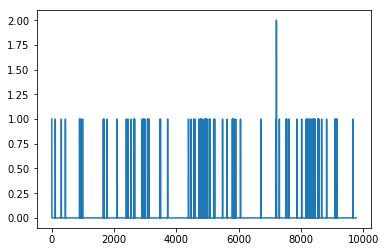

In [18]:
plt.plot(counts);

In [20]:
counts.index(2)

verses[counts.index(2)]

7215

In [22]:
import numpy as np
import scipy.ndimage as ndi

In [26]:
def density(values, blur=0.01):
    values = np.array(values, dtype=float)
    sigma = len(values) * blur
    blurred = ndi.gaussian_filter1d(values, sigma, mode='constant')
    return blurred / max(blurred)

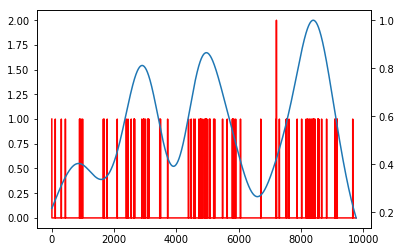

In [40]:
axes = plt.subplot()
axes.plot(counts, c='red')
axes.twinx().plot(density(counts, 0.05));

In [89]:
image = np.array(density(counts, 0.01)).reshape((1, len(counts)))

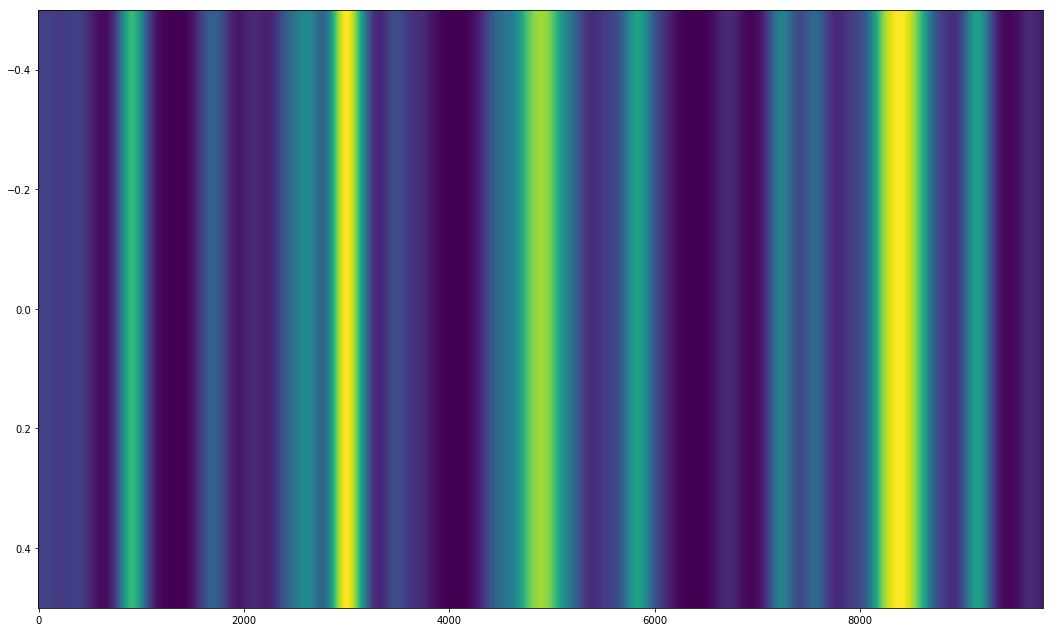

In [90]:
plt.figure(figsize=(18, 11))
axes = plt.subplot()
plt.imshow(image, aspect='auto');